<a href="https://colab.research.google.com/github/FatmaBuseBorlu/Dramer-Dataset-LSTM/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [160]:
from IPython.display import display
import numpy as np
import scipy.io as sio
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [161]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [162]:
# --- DREAMER veri setini yükleme fonksiyonu ---
def load_dreamer_data(file_path):
    data = sio.loadmat(file_path)
    eeg_data = []
    labels = []
    for participant in range(23):
        for video in range(18):
            stimuli = data['DREAMER'][0, 0]['Data'][0, participant]['EEG'][0, 0]['stimuli'][0, 0][video, 0]
            if stimuli.size == 0:
                continue
            if stimuli.shape[0] != 14:
                stimuli = stimuli.T
            eeg_data.append(stimuli)
            valence_score = data['DREAMER'][0, 0]['Data'][0, participant]['ScoreValence'][0, 0][video, 0]
            labels.append(valence_score)
    return eeg_data, np.array(labels)

In [163]:
# --- EEG verilerini ön işleme fonksiyonu ---
def preprocess_eeg_data(eeg_data, max_length=1000):
    padded_eeg_data = []
    for sample in eeg_data:
        if sample.shape[1] < max_length:
            padding_shape = ((0, 0), (0, max_length - sample.shape[1]))
            padded_sample = np.pad(sample, padding_shape, mode='constant', constant_values=0)
        else:
            padded_sample = sample[:, :max_length]
        padded_eeg_data.append(padded_sample)
    eeg_data = np.array(padded_eeg_data)
    scaler = StandardScaler()
    eeg_data = eeg_data.reshape(eeg_data.shape[0], -1)
    eeg_data = scaler.fit_transform(eeg_data)
    eeg_data = eeg_data.reshape(-1, max_length, 14)
    return eeg_data

In [164]:
# Veri yolu
file_path = "/content/drive/MyDrive/Colab Notebooks/DREAMER.mat"

In [165]:
# Veri setini yükleme
eeg_data, labels = load_dreamer_data(file_path)

In [166]:
# Veri ön işleme
eeg_data = preprocess_eeg_data(eeg_data)

In [167]:
# Etiketleri binary hale getirme
labels = LabelEncoder().fit_transform(labels > 5)  # Valence > 5 -> 1, aksi takdirde 0

In [168]:
# Eğitim ve test verilerini ayırma
X_train, X_test, y_train, y_test = train_test_split(eeg_data, labels, test_size=0.3, random_state=42)

In [169]:
# Sınıf ağırlıklarını hesaplama
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [170]:
# --- Model Tanımlama ---
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    Dropout(0.3),  # Daha düşük dropout oranı
    LSTM(32, return_sequences=False, kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [171]:
# --- Model Derleme ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Daha düşük öğrenme oranı
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [172]:
# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [173]:
# --- Modeli Eğitme ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,  # Batch boyutunu artırdık
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.2565 - loss: 2.3214 - val_accuracy: 0.4000 - val_loss: 1.3853
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.2867 - loss: 2.3176 - val_accuracy: 0.4320 - val_loss: 1.3819
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2796 - loss: 2.1949 - val_accuracy: 0.4560 - val_loss: 1.3785
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3140 - loss: 2.1420 - val_accuracy: 0.4880 - val_loss: 1.3744
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3218 - loss: 1.9773 - val_accuracy: 0.5040 - val_loss: 1.3699
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.2969 - loss: 2.0669 - val_accuracy: 0.5280 - val_loss: 1.3652
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.3842 - loss: 1.8871 - val_accuracy: 0.5520 - val_loss: 1.3594
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3759 - loss: 1.8152 - val_accuracy: 0.6080 - val_loss: 1.3539
Epoc

In [174]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 402ms/step - accuracy: 0.9769 - loss: 0.7422
Test Loss: 0.7364019751548767, Test Accuracy: 0.984000027179718


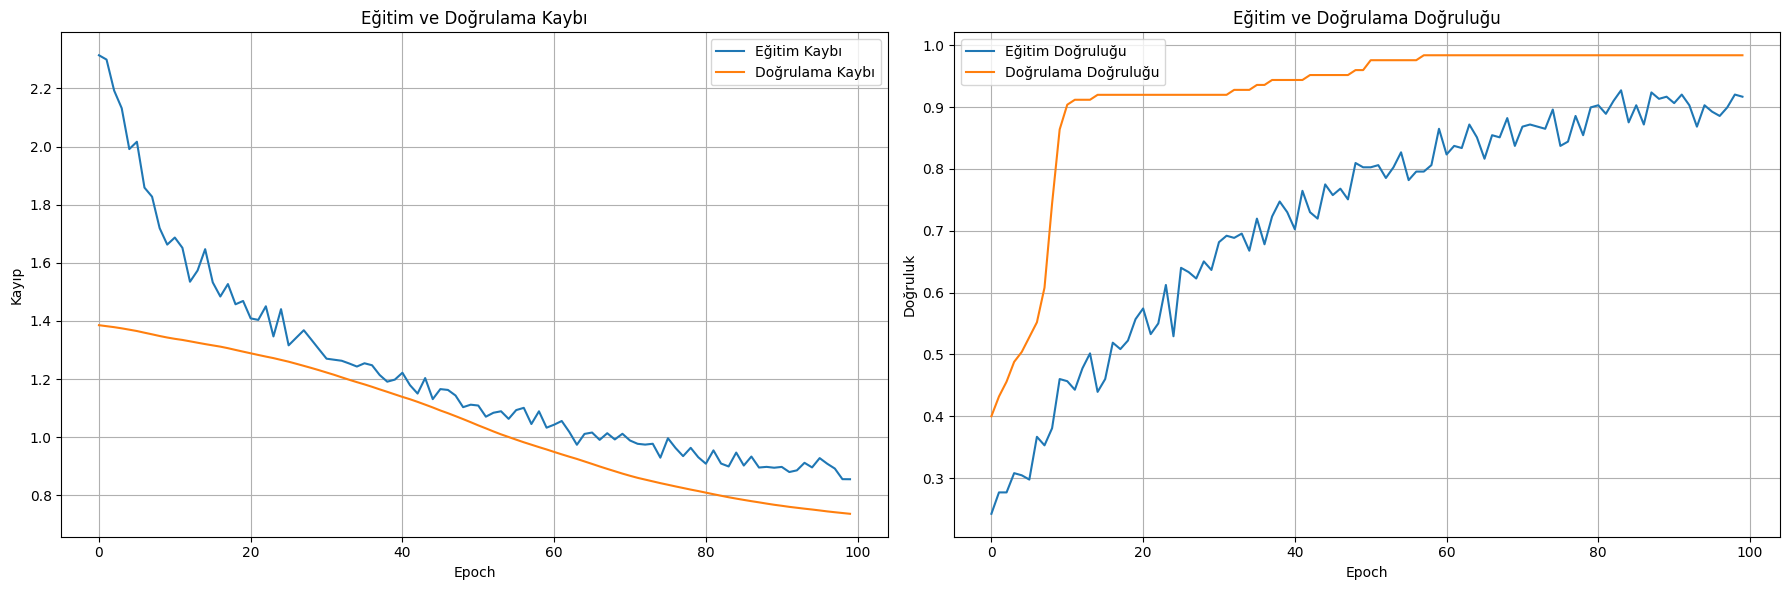

In [175]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kayıplarını ve doğruluklarını yan yana çizme
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Eğitim ve Doğrulama Kaybı
axes[0].plot(history.history['loss'], label='Eğitim Kaybı')
axes[0].plot(history.history['val_loss'], label='Doğrulama Kaybı')
axes[0].set_title("Eğitim ve Doğrulama Kaybı")
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Kayıp')
axes[0].legend()
axes[0].grid()

# Eğitim ve Doğrulama Doğruluğu
axes[1].plot(history.history['accuracy'], label='Eğitim Doğruluğu')
axes[1].plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
axes[1].set_title("Eğitim ve Doğrulama Doğruluğu")
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Doğruluk')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()
